In [4]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

In [13]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [14]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [22]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [43]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [44]:
nonlinear_model = NonlinearClassifier()
print(nonlinear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [11]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [45]:
%%time

epochs = 60
train_losses=[]
val_losses=[]
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, training accuracy: {acc}")
    train_losses.append(loss)

    # checking on the validation loss and accuracy once per epoch
    acc_val, loss_val = evaluate(val_dataloader, nonlinear_model, loss_fn)
    print(f"Epoch {j}: validation loss: {loss_val}, validation accuracy: {acc_val}")
    val_losses.append(loss_val)

Epoch 0: training loss: 2.0783064403533937, training accuracy: 45.33958333333333
Epoch 0: validation loss: 2.0779775076724114, validation accuracy: 45.733333333333334
Epoch 1: training loss: 1.2868047838211059, training accuracy: 70.02083333333333
Epoch 1: validation loss: 1.2844159755300968, validation accuracy: 70.15
Epoch 2: training loss: 0.811696624437968, training accuracy: 80.80833333333334
Epoch 2: validation loss: 0.8097939262998864, validation accuracy: 80.61666666666667
Epoch 3: training loss: 0.6158676985899607, training accuracy: 84.49583333333334
Epoch 3: validation loss: 0.6129346185542167, validation accuracy: 84.5
Epoch 4: training loss: 0.5180725544293722, training accuracy: 86.5375
Epoch 4: validation loss: 0.5136869460978406, validation accuracy: 86.45
Epoch 5: training loss: 0.4612279066244761, training accuracy: 87.67708333333334
Epoch 5: validation loss: 0.45596767137659355, validation accuracy: 87.70833333333333
Epoch 6: training loss: 0.4248817404905955, traini

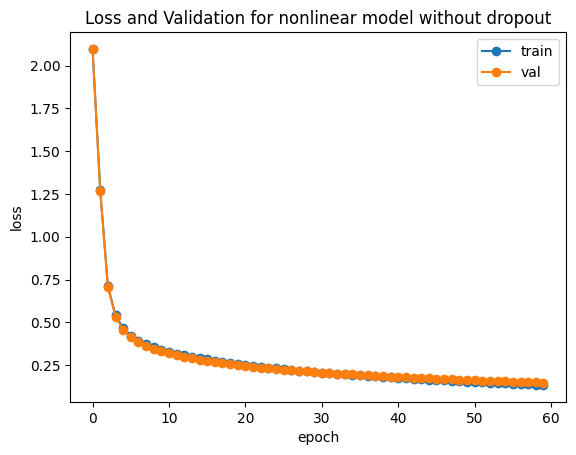

Lowest training loss: 0.1345627919236819, lowest validation loss: 0.14797224631493397


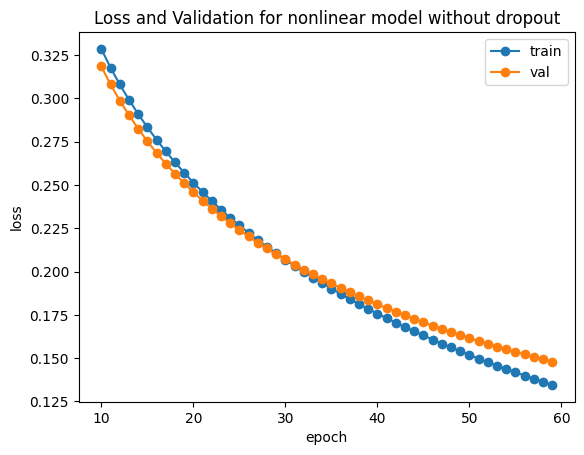

In [42]:
train_loss_x = numpy.arange(0,len(train_losses))
train_loss_y = numpy.asarray(train_losses)
val_loss_x = numpy.arange(0,len(val_losses))
val_loss_y = numpy.asarray(val_losses)
plt.plot(train_loss_x,train_loss_y, 'o-')
plt.plot(val_loss_x,val_loss_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss and Validation for nonlinear model without dropout')
plt.show()
print(f"Lowest training loss: {min(train_loss_y)}, lowest validation loss: {min(val_loss_y)}")
train_loss_x = numpy.arange(10,len(train_losses))
train_loss_y = numpy.asarray(train_losses[10:])
val_loss_x = numpy.arange(10,len(val_losses))
val_loss_y = numpy.asarray(val_losses[10:])
plt.plot(train_loss_x,train_loss_y, 'o-')
plt.plot(val_loss_x,val_loss_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss and Validation for nonlinear model without dropout')
plt.show()

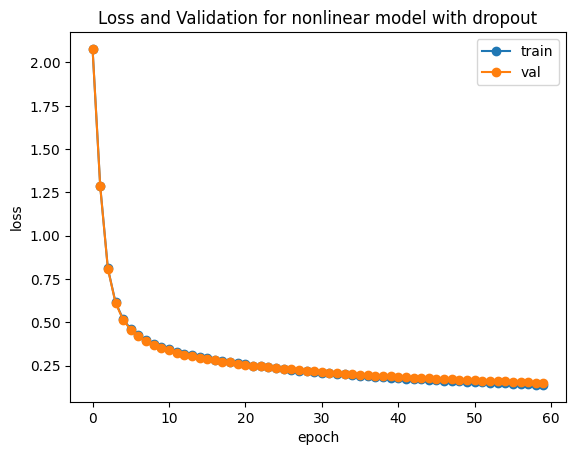

Lowest training loss: 0.13850193901856742, lowest validation loss: 0.15049107994963515


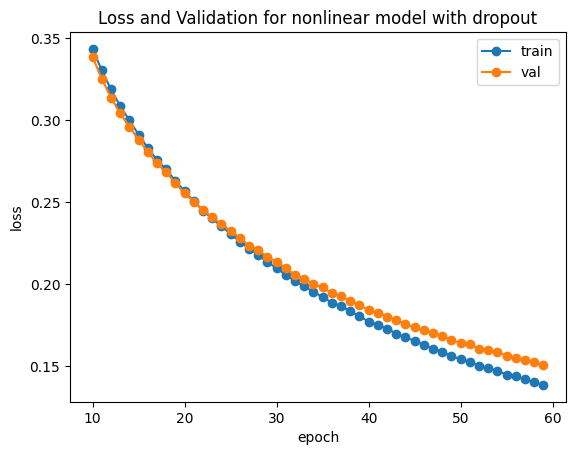

In [50]:
train_loss_x = numpy.arange(0,len(train_losses))
train_loss_y = numpy.asarray(train_losses)
val_loss_x = numpy.arange(0,len(val_losses))
val_loss_y = numpy.asarray(val_losses)
plt.plot(train_loss_x,train_loss_y, 'o-')
plt.plot(val_loss_x,val_loss_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss and Validation for nonlinear model with dropout')
plt.show()
print(f"Lowest training loss: {min(train_loss_y)}, lowest validation loss: {min(val_loss_y)}")
train_loss_x = numpy.arange(10,len(train_losses))
train_loss_y = numpy.asarray(train_losses[10:])
val_loss_x = numpy.arange(10,len(val_losses))
val_loss_y = numpy.asarray(val_losses[10:])
plt.plot(train_loss_x,train_loss_y, 'o-')
plt.plot(val_loss_x,val_loss_y, 'o-')
plt.legend(['train','val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss and Validation for nonlinear model with dropout')
plt.show()

In [51]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.1511, test accuracy: 95.29%
